1.5 -190.976 [0.1861678449777776, 0.00749110621515939]
1.6 -188.536 [0.23264470250000155, 0.009437012790450939]
1.7000000000000002 -187.816 [0.3129384193771626, 0.014018532095564685]
1.8000000000000003 -188.48 [0.40997200000000045, 0.017961511838244668]
1.9000000000000004 -182.144 [0.5297356037673143, 0.02797384560610284]
2.0000000000000004 -177.8 [0.5910412223999996, 0.027743610309966738]
2.1000000000000005 -170.104 [0.7071818347392282, 0.03153926388759947]
2.2000000000000006 -163.64 [0.9061217044628078, 0.03917623784619082]
2.3000000000000007 -155.776 [0.9071505070699419, 0.03627320144908071]
2.400000000000001 -144.544 [0.8889451188888888, 0.03342457016196175]
2.500000000000001 -117.512 [0.8355814666239998, 0.037638699721842916]
2.600000000000001 -100.976 [0.6977806144378692, 0.027797662990457182]
2.700000000000001 -102.528 [0.6530499766255137, 0.02728923154722221]
2.800000000000001 -88.112 [0.5149674808163262, 0.01960415323004879]
2.9000000000000012 -113.664 [0.438307206848989, 0.01

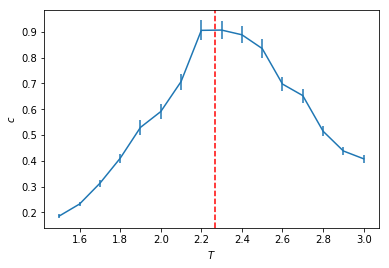

In [5]:
%run metropolis.py

In [45]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
@jit(nopython=True)
def energy(system, i, j, L):
    """Energy function of spins connected to site (i, j)."""
    return -1. * system[i, j] * (system[np.mod(i - 1, L), j] + system[np.mod(i + 1, L), j] +
                                 system[i, np.mod(j - 1, L)] + system[i, np.mod(j + 1, L)])

@jit
def prepare_system(L):
    """Initialize the system."""
    system = 2 * (0.5 - np.random.randint(0, 2, size=[L, L]))
    return system

@jit(nopython=True)
def measure_energy(system):
    L = system.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            E += energy(system, i, j, L) / 2.
    return E

@jit(nopython=True)
def metropolis_loop(system, T, N_sweeps, N_eq, N_flips):
    """ Main loop doing the Metropolis algorithm."""
    E = measure_energy(system)
    L = system.shape[0]
    E_list = []
    for step in range(N_sweeps + N_eq):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        dE = -2. * energy(system, i, j, L)
        if dE <= 0.:
            system[i, j] *= -1
            E += dE
        elif np.exp(-1. / T * dE) > np.random.rand():
            system[i, j] *= -1
            E += dE

        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E_list.append(E)
    return np.array(E_list)

In [47]:
Ls = np.array(range(2,10)) # Linear system size
N_sweeps = 5000  # Number of steps for the measurements
N_eq = 1000  # Number of equilibration steps before the measurements start
N_flips = 10  # Number of steps between measurements
N_bins = 100  # Number of bins use for the error analysis

T_range = np.arange(1.5, 3.1, 0.1)

C_list = []

systems = np.array([prepare_system(i) for i in Ls])
energyY = np.array([measure_energy(i) for i in systems])

#for L in Ls:
    for T in T_range:
        C_list_bin = []
        for k in range(N_bins):
            Es = metropolis_loop(system, T, N_sweeps, N_eq, N_flips)

            mean_E = np.mean(Es)
            mean_E2 = np.mean(Es**2)

            C_list_bin.append(1. / T**2. / L**2. * (mean_E2 - mean_E**2))
        C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])

        print(T, mean_E, C_list[-1])

IndentationError: unexpected indent (<ipython-input-47-7e207314f52b>, line 15)

Tc = 2.269185314213022


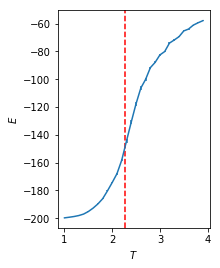

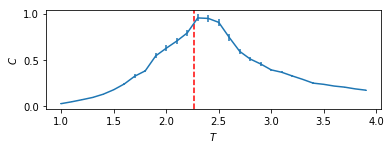

In [69]:
# Set parameters here
L = 10  # Linear system size
N_sweeps = 5000  # Number of steps for the measurements
N_eq = 1000  # Number of equilibration steps before the measurements start
N_flips = 10  # Number of steps between measurements
N_bins = 100  # Number of bins use for the error analysis

T_range = np.arange(1., 4., 0.1)

E_list = []
C_list = []
system = prepare_system(L)
for T in T_range:
    mean_E_bin = []
    C_list_bin = []
    for k in range(N_bins):
        Es = metropolis_loop(system, T, N_sweeps, N_eq, N_flips)

        mean_E_bin.append(np.mean(Es))
        mean_E2 = np.mean(Es**2)

        C_list_bin.append(1. / T**2. / L**2. * (mean_E2 - mean_E_bin[-1]**2))
    E_list.append([np.mean(mean_E_bin), np.std(mean_E_bin) / np.sqrt(N_bins)])
    C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])

    #print(T, E_list[-1], C_list[-1])

# Plot the results
plt.subplot(1,2,1)

E_list = np.array(E_list)
plt.errorbar(T_range, E_list[:, 0], E_list[:, 1])

Tc = 2. / np.log(1. + np.sqrt(2))
print("Tc =", Tc)
plt.axvline(Tc, color='r', linestyle='--')

plt.xlabel('$T$')
plt.ylabel('$E$')
plt.show()

plt.subplot(211)

C_list = np.array(C_list)
plt.errorbar(T_range, C_list[:, 0], C_list[:, 1])
plt.axvline(Tc, color='r', linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$C$')
plt.show()